# Flash ID validation 
Jupyter notebook to look at a PMT based neutrino ID for the LEE searches

## Imports

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import LogNorm
from operator import itemgetter
import helpfunction as helper
pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

## Constants

In [4]:
gr = 1.618
outdir= './output/FlashID/'
inputdir = './input/'  

mc_start = 3.16
bnb_start = mc_start + 2*0.015625 #3.19
ext_start = mc_start + 26*0.015625 #3.58
intime_start = 3.57  # mc_start + 26*0.015625 # 3.58
duration = 1.68
nrPMT = 32
rangePMT = range(nrPMT)

mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

In [5]:
dict_names = ['nue','nu','on','off'] #,'on_rolling'] 
shift_time = [0,0,0.03,0.42]
lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]
fidvol_arr = [10,10,10,10,10,50] 

## Definitions

In [6]:
# Creates a dict with only a selection of keys from the original dict, given as a list ks
def subdict(d, ks):
    return dict(zip(ks, itemgetter(*ks)(d)))

def inTPC(row):
    if 0 < row['_nu_vtx_x'] < 256.35:
        if 0 < row['_nu_vtx_z'] < 1036.8:
            if -116.5 < row['_nu_vtx_y'] < 116.5:
                return True
    return False   

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return df[mask]

## Loading inputs

In [7]:
file_dict = {}
first = True
start = time.time()

flist =  os.listdir(inputdir)
for sample in dict_names:
    file_name = next((s for s in flist if "NueCC_"+sample+"_" in s), None)
    file = uproot.open(inputdir+file_name)['pandoraFlashEventBuilding']
    file_dict[sample] = {}
    for tree_name in file.keys():
        name = tree_name.decode('UTF-8').split(';')[0]
        file_dict[sample][name] = file[tree_name].arrays(file[tree_name].keys())
        if first:
            print('*** ', name, ' ***')
            print(file[tree_name].keys())
            print()
    first = False
    print('Loaded',sample, 'sample:', len(file_dict[sample]['events'][b'event']))

print('Loading took  {0:.2f} seconds.'.format(time.time()-start))

***  metadata  ***
[b'beamWindowStart', b'beamWindowEnd', b'minBeamFlashPE', b'maxDeltaY', b'maxDeltaZ', b'maxDeltaYSigma', b'maxDeltaZSigma', b'minChargeToLightRatio', b'maxChargeToLightRatio', b'chargeToNPhotonsTrack', b'chargeToNPhotonsShower']

***  events  ***
[b'run', b'subRun', b'event', b'evt_time_sec', b'evt_time_nsec', b'nFlashes', b'nFlashesInBeamWindow', b'hasBeamFlash', b'nSlices', b'nSlicesAfterPrecuts', b'foundATargetSlice', b'targetSliceMethod', b'nuInteractionType', b'nuCCNC', b'nuEnergy', b'leptonEnergy', b'nuInteractionTime', b'nuPdgCode', b'nuVertexX', b'nuVertexY', b'nuVertexZ']

***  flashes  ***
[b'run', b'subRun', b'event', b'evt_time_sec', b'evt_time_nsec', b'time', b'centerY', b'centerZ', b'widthY', b'widthZ', b'totalPE', b'peSpectrum', b'inBeamWindow', b'isBrightestInWindow', b'isBeamFlash']

***  slices  ***
[b'sliceId', b'run', b'subRun', b'event', b'evt_time_sec', b'evt_time_nsec', b'hasDeposition', b'totalCharge', b'centerX', b'centerY', b'centerZ', b'min

## Quick checks

In [8]:
file_dict['on'].keys()

dict_keys(['events', 'metadata', 'slices', 'flashes'])

In [9]:
# Get the POT from the MC samples
pot_nue = sum(file_dict['nue']['subruns'][b'pot'])
print('Total POT in nue file: {0:.4g}'.format(pot_nue))
pot_nu = sum(file_dict['nu']['subruns'][b'pot'])
print('Total POT in nu file: {0:.4g}'.format(pot_nu))

Total POT in nue file: 4.574e+22
Total POT in nu file: 1.91e+20


In [10]:
if 0: # Only run once if you dont know the number of pot and triggers yet
    # Get the run subrun list from data samples
    samples = ['off']
    for sample in samples:
        out_name = outdir + 'run_subrun_' + sample + '.txt'
        run_subrun = np.array([file_dict[sample]['subruns'][b'run'], file_dict[sample]['subruns'][b'subRun']])
        # temp fix for not storing POT info
        #run_subrun = np.unique(np.array([file_dict[sample]['events'][b'run'], file_dict[sample]['events'][b'subRun']]), axis=1)
        np.savetxt(out_name, run_subrun.T, fmt='%d')

triggers_off = 10119897.0
triggers_on_rolling = 1337193
triggers_on = 10188735
pot_on_rolling = 5.736e+18
pot_on = 4.35e19
title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)

scale_off = triggers_on / triggers_off
scale_nu = pot_on / (pot_nu)
scale_nue = pot_on / (pot_nue)
scale_on = 1
scale_on_rolling = pot_on / pot_on_rolling

#['nue','nu','on','off', 'on_rolling'] 
scales = [scale_nue, scale_nu, scale_on, scale_off, scale_on_rolling]
print(scales)

[0.0009510529046483252, 0.22770676408583113, 1, 1.00680224314536, 7.583682008368201]


In [11]:
# For all events
sample= 'nue'
data = file_dict[sample]['events'][b'nFlashesInBeamWindow']
print('Events with flash in window: {0:.1f}%'.format(sum(data)/len(data)*100))
data = file_dict[sample]['events'][b'hasBeamFlash']
print('Events with flash in window and 50PE: {0:.1f}%'.format(sum(data)/len(data)*100))
nom = file_dict[sample]['events'][b'nSlicesAfterPrecuts']>0 
denom2 = file_dict[sample]['events'][b'nSlices']
print('Events passing the precuts: {0:.1f}%'.format(sum(nom)/len(denom2)*100))

denom = (file_dict[sample]['slices'][b'completeness'] > 0.8) & (file_dict[sample]['slices'][b'purity'] > 0.8)
nom = (file_dict[sample]['slices'][b'isTaggedAsTarget'])

print('Selected slice is purity and complete slice (opt sel performance metric): {0:.1f}%'.format(sum(nom & denom)/sum(denom)*100))
print('Percentage of events with a complete/pure neutrino slice: {0:.1f}%'.format(sum(denom)/len(denom2)*100))

Events with flash in window: 97.1%
Events with flash in window and 50PE: 96.9%
Events passing the precuts: 81.8%
Selected slice is purity and complete slice (opt sel performance metric): 87.1%
Percentage of events with a complete/pure neutrino slice: 58.7%


In [12]:
# Signal if the true vertex is inside the fiducial volume and the lepton has more than 20MeV kinetic energy
df_nue_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nue']['events']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nue_sig.columns = [c.decode('UTF-8') for c in df_nue_sig.columns ]
df_nue_sig = df_nue_sig.query('leptonEnergy>@kin_min') 
df_nu_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nu']['events']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nu_sig.columns = [c.decode('UTF-8') for c in df_nu_sig.columns ]
df_nu_sig = df_nu_sig.query('leptonEnergy>@kin_min_mu & ~nuCCNC & abs(nuPdgCode)==14')

# First, construct signal frame!
df_nue_slices_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nue']['slices']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nue_slices_sig.columns = [c.decode('UTF-8') for c in df_nue_slices_sig.columns ]
df_nue_slices_sig = df_nue_slices_sig.query('leptonEnergy>@kin_min')
df_nu_slices_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nu']['slices']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nu_slices_sig.columns = [c.decode('UTF-8') for c in df_nu_slices_sig.columns ]
df_nu_slices_sig = df_nu_slices_sig.query('leptonEnergy>@kin_min_mu & ~nuCCNC & abs(nuPdgCode)==14')

df_nue_sig.head()

,event,evt_time_nsec,evt_time_sec,foundATargetSlice,hasBeamFlash,leptonEnergy,nFlashes,nFlashesInBeamWindow,nSlices,nSlicesAfterPrecuts,nuCCNC,nuEnergy,nuInteractionTime,nuInteractionType,nuPdgCode,nuVertexX,nuVertexY,nuVertexZ,run,subRun,targetSliceMethod
0,11181,2580339355,359189994,False,False,1.278986,1,0,4,-2147483647,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,1,560,-1
1,11182,1868056598,359189997,True,True,0.573900,1,1,5,1,0,0.665641,3894.953613,1001,12,16.434252,-73.792023,538.791870,1,560,0
2,11183,297755143,359190000,True,True,0.485253,1,1,5,1,0,0.739412,3633.188721,1001,12,100.758636,55.153923,520.921204,1,560,0
3,11184,1926027480,359190002,True,True,0.227346,1,1,6,1,0,0.576200,4055.550781,1000,12,121.717331,19.540274,861.082825,1,560,0
4,11185,3712335145,359190004,False,True,0.342515,1,1,4,0,0,0.466381,3815.602051,1001,12,215.986267,-41.932060,111.769791,1,560,-1


In [13]:
df_nue_slices_sig.head()

,centerX,centerY,centerZ,chargeToLightRatio,completeness,deltaY,deltaYSigma,deltaZ,deltaZSigma,event,evt_time_nsec,evt_time_sec,flashMatchScore,flashMatchX,hasBestFlashMatchScore,hasBestTopologicalScore,hasDeposition,isConsideredByFlashId,isMostComplete,isTaggedAsTarget,leptonEnergy,minX,nHits,nuCCNC,nuEnergy,nuInteractionTime,nuInteractionType,nuPdgCode,nuVertexX,nuVertexY,nuVertexZ,passesPreCuts,peHypothesisSpectrum,purity,run,sliceId,subRun,targetMethod,topologicalScore,totalCharge,totalPEHypothesis,xclVariable
0,84.821205,43.610718,998.208374,-3.402823e+38,0.000000,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,7.673082e-28,False,False,True,False,False,False,1.278986,65.077888,713,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.000000,1,1,560,-2147483647,0.009860,32356.960938,-3.402823e+38,-3.402823e+38
1,121.805061,-8.987331,795.852783,-3.402823e+38,0.000000,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,-1.279324e+22,False,True,True,False,False,False,1.278986,0.345705,2125,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.000000,1,2,560,-2147483647,0.837426,88140.632812,-3.402823e+38,-3.402823e+38
2,198.627563,-82.531609,696.154480,-3.402823e+38,0.000000,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,0.000000e+00,False,False,True,False,False,False,1.278986,198.051910,959,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.000000,1,3,560,-2147483647,0.000000,14245.261719,-3.402823e+38,-3.402823e+38
3,249.407654,-81.562439,315.196594,-3.402823e+38,0.394366,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,-1.101110e+23,False,False,True,False,True,False,1.278986,245.992294,196,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.857143,1,4,560,-2147483647,0.111463,9111.935547,-3.402823e+38,-3.402823e+38
4,102.307877,-21.323362,232.379868,1.597130e+01,0.000000,1.269201e+01,3.439677e-01,-3.176615e+02,-3.841277e+00,11182,1868056598,359189997,-3.402823e+38,0.000000e+00,False,False,True,True,False,False,0.573900,79.170776,1035,0,0.665641,3894.953613,1001,12,16.434252,-73.792023,538.791870,False,[],0.000000,1,1,560,-2147483647,0.002215,42021.468750,-3.402823e+38,1.263268e+02


In [14]:
num_sig_nue = len(df_nue_sig.index)
num_sig_nu = len(df_nu_sig.index)
frq = sum(df_nue_sig['nFlashesInBeamWindow'])/num_sig_nue
err = helper.effErr(sum(df_nue_sig['nFlashesInBeamWindow']), num_sig_nue)
print('Events with flash in window: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))
frq = sum(df_nue_sig['hasBeamFlash'])/num_sig_nue
err = helper.effErr(sum(df_nue_sig['hasBeamFlash']), num_sig_nue)
print('Events with 50PE flash in window: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))
frq = sum(df_nue_sig['nSlicesAfterPrecuts']>0)/num_sig_nue
err = helper.effErr(sum(df_nue_sig['nSlicesAfterPrecuts']>0), num_sig_nue)
print('Events passing optical selection: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))

Events with flash in window: (97.64+-0.06)%
Events with 50PE flash in window: (97.57+-0.06)%
Events passing optical selection: (87.12+-0.12)%


In [15]:
mask = df_nue_slices_sig.eval('isTaggedAsTarget & isMostComplete')
frq = sum(mask)/num_sig_nue
err = helper.effErr(sum(mask), num_sig_nue)
print('Events where most complete slice passes the optical selection: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))

mask = df_nue_slices_sig.eval('isTaggedAsTarget & completeness>0.8 & purity>0.8')
mask_denom = df_nue_slices_sig.eval('completeness>0.8 & purity>0.8')
frq = sum(mask)/sum(mask_denom)
err = helper.effErr(sum(mask), sum(mask_denom))
print('80%+Pure/Complete slices passing the selection: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))


Events where most complete slice passes the optical selection: (82.70+-0.14)%
80%+Pure/Complete slices passing the selection: (92.17+-0.13)%


In [16]:
sample = "off"
passf = file_dict[sample]['events'][b'nSlicesAfterPrecuts']>0
print("Percentage of events passing in BNB off: {0:.1f}%".format(sum(passf)*100/len(passf)))
sample = "on"
passf = file_dict[sample]['events'][b'nSlicesAfterPrecuts']>0
print("Percentage of events passing in BNB on: {0:.1f}%".format(sum(passf)*100/len(passf)))

Percentage of events passing in BNB off: 21.4%
Percentage of events passing in BNB on: 30.5%


## Flash plots

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


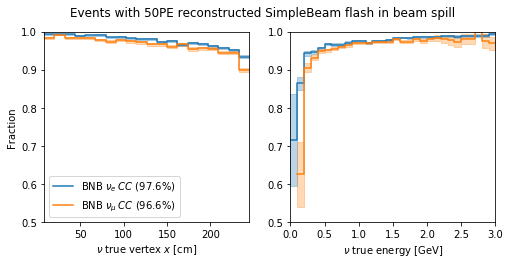

In [17]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle('Events with 50PE reconstructed SimpleBeam flash in beam spill')

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 21
edges = np.linspace(x_min,x_max,N)
nom_bins, _ = np.histogram(df_nue_sig.query('hasBeamFlash')['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_nue_sig['nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ratio = sum(nom_bins)/sum(denom_bins)
ax[0].step(edges, fraq, where='post',  label = r'BNB $\nu_e \: CC$ ({0:.1f}%)'.format(ratio*100))
ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')

nom_bins, _ = np.histogram(df_nu_sig.query('hasBeamFlash')['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_nu_sig['nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ratio = sum(nom_bins)/sum(denom_bins)
ax[0].step(edges, fraq, where='post', label = r'BNB $\nu_\mu \: CC$ ({0:.1f}%)'.format(ratio*100))
ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')

ax[0].legend()
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlabel(r'$\nu$ true vertex $x$ [cm]')
ax[0].set_xlim(x_min,x_max)

# Right
x_min = 0
x_max = 3
N = 31
edges = np.linspace(x_min,x_max,N)
nom_bins, _ = np.histogram(df_nue_sig.query('hasBeamFlash')['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_nue_sig['nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[1].step(edges, fraq, where='post')
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')

nom_bins, _ = np.histogram(df_nu_sig.query('hasBeamFlash')['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_nu_sig['nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[1].step(edges, fraq, where='post')
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')

ax[1].set_xlabel(r'$\nu$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min,x_max)

fig.savefig( outdir+"flash_eff_nue.pdf", bbox_inches="tight")

In [18]:
# Flash PE and timing plot!
# Check if the flash frame is complete:
print(sum(file_dict[sample]['events'][b'nFlashes']))
print(len(file_dict[sample]['flashes'][b'run']))
# Yes! We can trust flashes

186151
186151


In [19]:
# data/MC ratio events with valid flash:
ratio = len(file_dict["on"]['events'][b'hasBeamFlash']) / (len(file_dict["nu"]['events'][b'hasBeamFlash'])*scales[1]+ len(file_dict["off"]['events'][b'hasBeamFlash'])*scales[3])
print(ratio)
ratio = sum(file_dict["on"]['events'][b'hasBeamFlash']) / (sum(file_dict["nu"]['events'][b'hasBeamFlash'])*scales[1]+ sum(file_dict["off"]['events'][b'hasBeamFlash'])*scales[3])
print(ratio)

frq = sum(file_dict["off"]['events'][b'hasBeamFlash'])/len(file_dict["off"]['events'][b'hasBeamFlash'])
err = helper.effErr(sum(file_dict["off"]['events'][b'hasBeamFlash']),len(file_dict["off"]['events'][b'hasBeamFlash']))
print('Fraction of BNB off events with a flash of at least 50PE in the beam window: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))

0.9868517185563693
1.142834351081805
Fraction of BNB off events with a flash of at least 50PE in the beam window: (61.47+-0.13)%


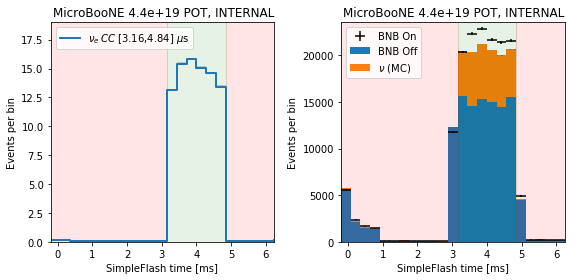

In [20]:
N=23
duration/5
x_min = mc_start-0.28*12
x_max = 0.28*5+mc_start+duration
field = b'time'
lab = 'SimpleFlash time [ms]'

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True)
data = [file_dict[s]['flashes'][field]-dt for s,dt in zip(dict_names, shift_time)]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
widths = (edges_mid - edges[:-1])

# Nue MC
mean = np.mean(data[0][data[0]>-1])
bins[0]=np.append(bins[0],bins[0][0])
err[0]=np.append(err[0],err[0][0])
ax[0].step(edges,bins[0], lw=2, where='post', label=r'$\nu_e \: CC$ [3.16,4.84] $\mu$s'.format(mean))
ax[0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0,1.2*max_val[0])
ax[0].set_xlabel(lab)
ax[0].set_ylabel('Events per bin')
ax[0].set_title(title_str, loc='right')
ax[0].legend()

# Data/MC
ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt="none",label="BNB On")
ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
y_err = np.sqrt(err[1]**2+err[3])
val = bins[3]+bins[1]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

ax[1].legend()
ax[1].set_xlabel(lab)
ax[1].set_ylabel('Events per bin')
ax[1].set_title(title_str, loc='right')
ax[1].set_ylim(0,1.03*max_val[2])

ax[1].axvspan(x_min,mc_start, alpha=0.1, color="red")
ax[1].axvspan(mc_start,mc_start+duration, alpha=0.1, color="green")
ax[1].axvspan(mc_start+duration,x_max, alpha=0.1, color="red")
ax[0].axvspan(x_min,mc_start, alpha=0.1, color="red")
ax[0].axvspan(mc_start,mc_start+duration, alpha=0.1, color="green")
ax[0].axvspan(mc_start+duration,x_max, alpha=0.1, color="red")


fig.tight_layout()
fig.savefig(outdir+field.decode('UTF-8')+".pdf", bbox_inches="tight")

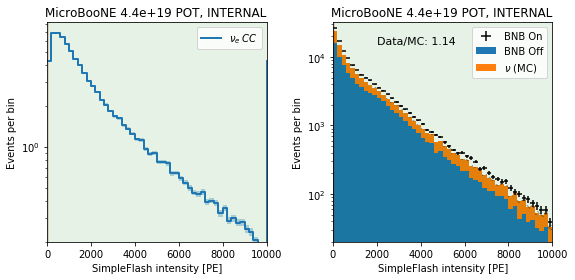

In [21]:
N=50
x_min = 0
x_max = 10000
field = b'totalPE'
lab = 'SimpleFlash intensity [PE]'

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True)
masks = [file_dict[s]['flashes'][b'inBeamWindow'] for s in dict_names]
data = [file_dict[s]['flashes'][field][m] for s,m in zip(dict_names, masks)]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
widths = (edges_mid - edges[:-1])

# Nue MC
mean = np.mean(data[0][data[0]>-1])
bins[0]=np.append(bins[0],bins[0][0])
err[0]=np.append(err[0],err[0][0])
ax[0].step(edges,bins[0], lw=2, where='post', label=r'$\nu_e \: CC$'.format(mean))
ax[0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0.2,1.2*max_val[0])
ax[0].set_xlabel(lab)
ax[0].set_ylabel('Events per bin')
ax[0].set_title(title_str, loc='right')
ax[0].legend()

# Data/MC
ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt="none",label="BNB On")
ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
y_err = np.sqrt(err[1]**2+err[3])
val = bins[3]+bins[1]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

ax[1].legend()
ax[1].set_xlabel(lab)
ax[1].set_ylabel('Events per bin')
ax[1].set_title(title_str, loc='right')
ax[1].set_ylim(20,1.2*max_val[2])

ax[1].axvspan(x_min,50, alpha=0.1, color="red")
ax[1].axvspan(50,x_max, alpha=0.1, color="green")
ax[0].axvspan(x_min,50, alpha=0.1, color="red")
ax[0].axvspan(50,x_max, alpha=0.1, color="green")
ax[1].set_yscale("log")
ax[0].set_yscale("log")
ax[1].text(0.2, 0.9, r'Data/MC: {0:0.2f}'.format(ratio), transform=ax[1].transAxes, size=11)

fig.tight_layout()
fig.savefig(outdir+field.decode('UTF-8')+".pdf", bbox_inches="tight")

## Slice plots

In [22]:
# Be careful:
# Nue sample is all inside TPC, nu sample is in full cryostat!

In [23]:
field_arr = [b'nSlices', b'nSlicesAfterPrecuts', b'nFlashes', b'nFlashesInBeamWindow', b'foundATargetSlice']
N_arr = [10,5,4,2,2]
x_min_arr = [-0.5]*5
x_max_arr = [9.5,4.5, 3.5,1.5,1.5]
apply_mask_arr = [1,1,0,0,1]
label_arr = ['Number of slices per event', 'Number of slices after precuts', 'Number of flashes per event', 
             'Number of flashes in spill', 'Tagged as neutrino']

arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr, apply_mask_arr]

1.1464210654609857
1.1428570854643565
0.9868517185563696
0.9868517185563696
1.142834351081805


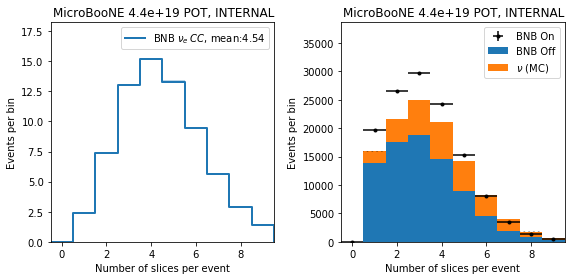

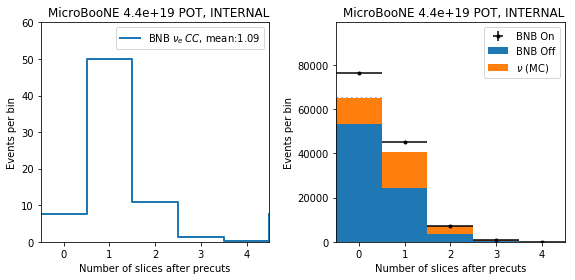

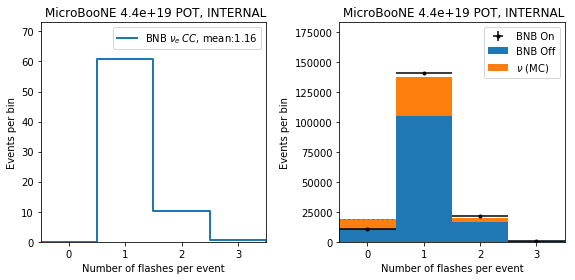

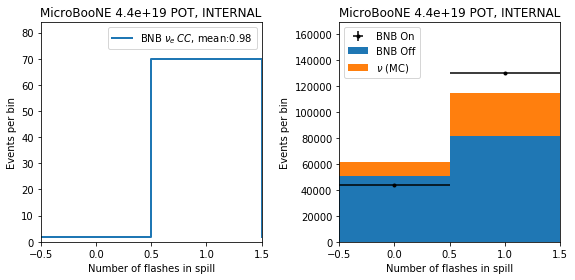

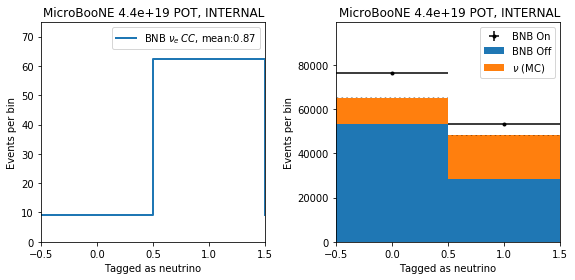

In [24]:
for field, N, x_min, x_max, lab, apply_mask in zip(*arrays):
    
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True)
    if apply_mask:
        mask = [file_dict[s]['events'][b'hasBeamFlash'] for s in dict_names]
        data = [file_dict[s]['events'][field][m] for s,m in zip(dict_names,mask)]
        scales_here = scales
    else:
        data = [file_dict[s]['events'][field] for s in dict_names]
        scales_here = scales
    # I need a signal sample for nue, overwrite it!    
    data[0] = df_nue_sig[field.decode('UTF-8')]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])
    
    # Nue MC
    mean = np.mean(data[0][data[0]>-1])
    bins[0]=np.append(bins[0],bins[0][0])
    err[0]=np.append(err[0],err[0][0])
    ax[0].step(edges,bins[0], lw=2, where='post', label=r'BNB $\nu_e \: CC$, mean:{0:0.2f}'.format(mean))
    ax[0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
    ax[0].set_xlim(x_min,x_max)
    ax[0].set_ylim(0,1.2*max_val[0])
    ax[0].set_xlabel(lab)
    ax[0].set_ylabel('Events per bin')
    ax[0].set_title(title_str, loc='right')
    ax[0].legend()

    # Data/MC
    ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
    y_err = np.sqrt(err[1]**2+err[3])
    val = bins[3]+bins[1]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    
    #Notice that slices after cuts implies having a beamflash
    print( sum(bins[2])/(sum(bins[1])+sum(bins[3])))
    ax[1].legend()
    ax[1].set_xlabel(lab)
    ax[1].set_ylabel('Events per bin')
    ax[1].set_title(title_str, loc='right')
    ax[1].set_ylim(0,1.3*max_val[2])

    fig.tight_layout()
    fig.savefig(outdir+field.decode('UTF-8')+".pdf", bbox_inches="tight")

In [25]:
## How many events do have a good slice:
# 80% pure and complete, and collection plane charge!

query_pure = '(purity>0.8)'
query_complete = '(completeness>0.8)'
query_good = query_pure+' & '+query_complete
query_has_flash = '(isConsideredByFlashId)'
query_good_flash = query_good+' & '+query_has_flash
query_has_deposition = '(hasDeposition)'
query_perfect = query_good_flash+' & '+query_has_deposition

query_perfect_flash_id = query_perfect+' & (hasBestFlashMatchScore)'
query_perfect_combi_id = query_perfect+' & (isTaggedAsTarget)'
query_perfect_topo_id = query_perfect+' & (hasBestTopologicalScore)'

query_all = "isMostComplete"
query_all_flash_id = query_all+' & (hasBestFlashMatchScore)'
query_all_combi_id = query_all+' & (isTaggedAsTarget)'
query_all_topo_id = query_all+' & (hasBestTopologicalScore)'

In [26]:
df_nue_slices_sig.head(5)

,centerX,centerY,centerZ,chargeToLightRatio,completeness,deltaY,deltaYSigma,deltaZ,deltaZSigma,event,evt_time_nsec,evt_time_sec,flashMatchScore,flashMatchX,hasBestFlashMatchScore,hasBestTopologicalScore,hasDeposition,isConsideredByFlashId,isMostComplete,isTaggedAsTarget,leptonEnergy,minX,nHits,nuCCNC,nuEnergy,nuInteractionTime,nuInteractionType,nuPdgCode,nuVertexX,nuVertexY,nuVertexZ,passesPreCuts,peHypothesisSpectrum,purity,run,sliceId,subRun,targetMethod,topologicalScore,totalCharge,totalPEHypothesis,xclVariable
0,84.821205,43.610718,998.208374,-3.402823e+38,0.000000,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,7.673082e-28,False,False,True,False,False,False,1.278986,65.077888,713,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.000000,1,1,560,-2147483647,0.009860,32356.960938,-3.402823e+38,-3.402823e+38
1,121.805061,-8.987331,795.852783,-3.402823e+38,0.000000,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,-1.279324e+22,False,True,True,False,False,False,1.278986,0.345705,2125,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.000000,1,2,560,-2147483647,0.837426,88140.632812,-3.402823e+38,-3.402823e+38
2,198.627563,-82.531609,696.154480,-3.402823e+38,0.000000,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,0.000000e+00,False,False,True,False,False,False,1.278986,198.051910,959,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.000000,1,3,560,-2147483647,0.000000,14245.261719,-3.402823e+38,-3.402823e+38
3,249.407654,-81.562439,315.196594,-3.402823e+38,0.394366,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,11181,2580339355,359189994,-3.402823e+38,-1.101110e+23,False,False,True,False,True,False,1.278986,245.992294,196,0,1.902040,4004.653320,1001,12,242.477448,-90.273994,309.265625,False,[],0.857143,1,4,560,-2147483647,0.111463,9111.935547,-3.402823e+38,-3.402823e+38
4,102.307877,-21.323362,232.379868,1.597130e+01,0.000000,1.269201e+01,3.439677e-01,-3.176615e+02,-3.841277e+00,11182,1868056598,359189997,-3.402823e+38,0.000000e+00,False,False,True,True,False,False,0.573900,79.170776,1035,0,0.665641,3894.953613,1001,12,16.434252,-73.792023,538.791870,False,[],0.000000,1,1,560,-2147483647,0.002215,42021.468750,-3.402823e+38,1.263268e+02


In [27]:
df_nue_slices_sig.keys()

Index(['centerX', 'centerY', 'centerZ', 'chargeToLightRatio', 'completeness',
       'deltaY', 'deltaYSigma', 'deltaZ', 'deltaZSigma', 'event',
       'evt_time_nsec', 'evt_time_sec', 'flashMatchScore', 'flashMatchX',
       'hasBestFlashMatchScore', 'hasBestTopologicalScore', 'hasDeposition',
       'isConsideredByFlashId', 'isMostComplete', 'isTaggedAsTarget',
       'leptonEnergy', 'minX', 'nHits', 'nuCCNC', 'nuEnergy',
       'nuInteractionTime', 'nuInteractionType', 'nuPdgCode', 'nuVertexX',
       'nuVertexY', 'nuVertexZ', 'passesPreCuts', 'peHypothesisSpectrum',
       'purity', 'run', 'sliceId', 'subRun', 'targetMethod',
       'topologicalScore', 'totalCharge', 'totalPEHypothesis', 'xclVariable'],
      dtype='object')

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


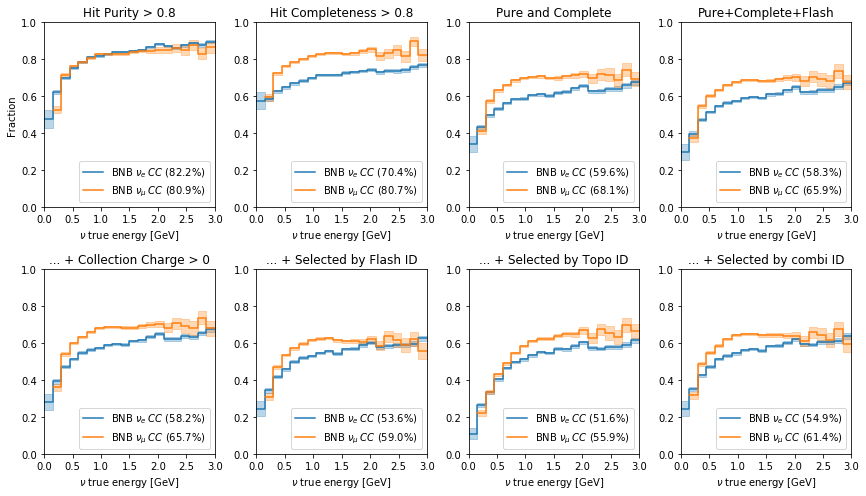

In [28]:
fig,ax=plt.subplots(ncols=4,nrows=2,figsize=(7.5*gr,7))
ax=ax.flatten()
q_arr = [query_pure, query_complete, query_good, query_good_flash, 
         query_perfect, query_perfect_flash_id, query_perfect_topo_id, query_perfect_combi_id]
title_arr = ['Hit Purity > 0.8', 'Hit Completeness > 0.8', 'Pure and Complete', 'Pure+Complete+Flash', 
             '... + Collection Charge > 0', '... + Selected by Flash ID', '... + Selected by Topo ID', '... + Selected by combi ID']

x_min = 0
x_max = 3
N = 21
edges = np.linspace(x_min,x_max,N)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
# in the denominator we use the event frames, one entry per event
denom_bins_nue, _ = np.histogram(df_nue_sig['nuEnergy'], bins=edges)
denom_bins_nu, _ = np.histogram(df_nu_sig['nuEnergy'], bins=edges)

for i,(query, title) in enumerate(zip(q_arr, title_arr)):
    #nue
    nom_bins, _ = np.histogram(df_nue_slices_sig.query(query).drop_duplicates(['evt_time_nsec'])['nuEnergy'], bins=edges)
    fraq = nom_bins/denom_bins_nue
    ratio = sum(nom_bins)/sum(denom_bins_nue)
    err = np.sqrt( fraq*(1-fraq)/denom_bins_nue)
    fraq=np.append(fraq,fraq[-1])
    err=np.append(err,err[-1])
    ax[i].step(edges, fraq, where='post', label = r'BNB $\nu_e \: CC$ ({0:.1f}%)'.format(ratio*100))
    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')
    #nu
    nom_bins, _ = np.histogram(df_nu_slices_sig.query(query).drop_duplicates(['evt_time_nsec'])['nuEnergy'], bins=edges)
    fraq = nom_bins/denom_bins_nu
    ratio = sum(nom_bins)/sum(denom_bins_nu)
    err = np.sqrt( fraq*(1-fraq)/denom_bins_nu)
    fraq=np.append(fraq,fraq[-1])
    err=np.append(err,err[-1])
    ax[i].step(edges, fraq, where='post', label = r'BNB $\nu_\mu \: CC$ ({0:.1f}%)'.format(ratio*100))
    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')
    ax[i].legend(loc='lower right')
    ax[i].set_xlabel(r'$\nu$ true energy [GeV]')
    ax[i].set_title(title)
    ax[i].set_ylim(0.0,1)
    ax[i].set_xlim(x_min,x_max)
    ax[i].set_xticks(np.linspace(0,3,7))
    
ax[0].set_ylabel('Fraction')
fig.tight_layout()
fig.savefig( outdir+"slice_eff_mc.pdf", bbox_inches="tight")

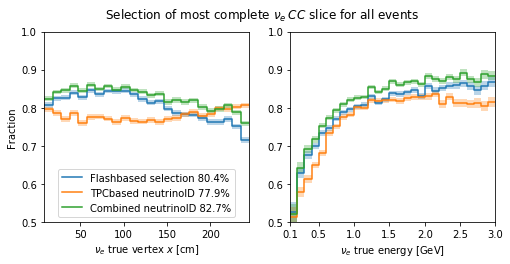

In [29]:
# Make the plot to compare the topological score with the flashbased selection:
x_nue_flash = df_nue_slices_sig.query(query_all_flash_id)['nuVertexX']
x_nue_topo = df_nue_slices_sig.query(query_all_topo_id)['nuVertexX']
x_nue_combi = df_nue_slices_sig.query(query_all_combi_id)['nuVertexX']
x_nue_denom = df_nue_slices_sig.query(query_all)['nuVertexX']

E_nue_flash = df_nue_slices_sig.query(query_all_flash_id)['nuEnergy']
E_nue_topo = df_nue_slices_sig.query(query_all_topo_id)['nuEnergy']
E_nue_combi = df_nue_slices_sig.query(query_all_combi_id)['nuEnergy']
E_nue_denom = df_nue_slices_sig.query(query_all)['nuEnergy']

ratio_flash = len(df_nue_slices_sig.query(query_all_flash_id))/len(df_nue_slices_sig.query(query_all))
ratio_topo = len(df_nue_slices_sig.query(query_all_topo_id))/len(df_nue_slices_sig.query(query_all))
ratio_combi = len(df_nue_slices_sig.query(query_all_combi_id))/len(df_nue_slices_sig.query(query_all))

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle(r'Selection of most complete $\nu_e \: CC$ slice for all events')
labels = [
    'Flashbased selection {0:.1f}%'.format(ratio_flash*100),
    'TPCbased neutrinoID {0:.1f}%'.format(ratio_topo*100),
    'Combined neutrinoID {0:.1f}%'.format(ratio_combi*100),
]

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 24
data = [x_nue_denom,x_nue_flash,x_nue_topo, x_nue_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[0].step(edges, f, where='post', label = l)
    ax[0].fill_between(edges, f - e, f + e, alpha=0.3, step='post')

ax[0].set_xlabel(r'$\nu_e$ true vertex $x$ [cm]')
ax[0].legend(loc='lower center')
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlim(x_min, x_max)

# Right
x_min = 0.1
x_max = 3
N = 29
data = [E_nue_denom,E_nue_flash,E_nue_topo, E_nue_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[1].step(edges, f, where='post', label = l)
    ax[1].fill_between(edges, f - e, f + e, alpha=0.3, step='post')
    
ax[1].set_xlabel(r'$\nu_e$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min, x_max)
ax[1].set_xticks([0.1,0.5,1,1.5,2,2.5,3])

fig.savefig( outdir+"ID_nue_all.pdf", bbox_inches="tight")

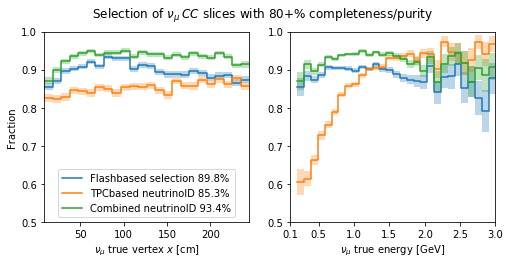

In [31]:
# Make the plot to compare the topological score with the flashbased selection:
x_nue_flash = df_nu_slices_sig.query(query_perfect_flash_id)['nuVertexX']
x_nue_topo = df_nu_slices_sig.query(query_perfect_topo_id)['nuVertexX']
x_nue_combi = df_nu_slices_sig.query(query_perfect_combi_id)['nuVertexX']
x_nue_denom = df_nu_slices_sig.query(query_perfect)['nuVertexX']

E_nue_flash = df_nu_slices_sig.query(query_perfect_flash_id)['nuEnergy']
E_nue_topo = df_nu_slices_sig.query(query_perfect_topo_id)['nuEnergy']
E_nue_combi = df_nu_slices_sig.query(query_perfect_combi_id)['nuEnergy']
E_nue_denom = df_nu_slices_sig.query(query_perfect)['nuEnergy']

ratio_flash = len(df_nu_slices_sig.query(query_perfect_flash_id))/len(df_nu_slices_sig.query(query_perfect))
ratio_topo = len(df_nu_slices_sig.query(query_perfect_topo_id))/len(df_nu_slices_sig.query(query_perfect))
ratio_combi = len(df_nu_slices_sig.query(query_perfect_combi_id))/len(df_nu_slices_sig.query(query_perfect))

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle(r'Selection of $\nu_{\mu} \: CC$ slices with 80+% completeness/purity')
labels = [
    'Flashbased selection {0:.1f}%'.format(ratio_flash*100),
    'TPCbased neutrinoID {0:.1f}%'.format(ratio_topo*100),
    'Combined neutrinoID {0:.1f}%'.format(ratio_combi*100),
]

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 24
data = [x_nue_denom,x_nue_flash,x_nue_topo, x_nue_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[0].step(edges, f, where='post', label = l)
    ax[0].fill_between(edges, f - e, f + e, alpha=0.3, step='post')

ax[0].set_xlabel(r'$\nu_{\mu}$ true vertex $x$ [cm]')
ax[0].legend(loc='lower center')
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlim(x_min, x_max)

# Right
x_min = 0.2
x_max = 3
N = 29
data = [E_nue_denom,E_nue_flash,E_nue_topo, E_nue_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[1].step(edges, f, where='post', label = l)
    ax[1].fill_between(edges, f - e, f + e, alpha=0.3, step='post')
    
ax[1].set_xlabel(r'$\nu_{\mu}$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min, x_max)
ax[1].set_xticks([0.1,0.5,1,1.5,2,2.5,3])

fig.savefig( outdir+"ID_nue.pdf", bbox_inches="tight")

## Plots

In [104]:
# Plots 
plot_fields_bin = [b'deltaZ', b'deltaZSigma', b'deltaY', b'deltaYSigma', b'xclVariable', b'topologicalScore']
plot_x_axis = [r"Charge $z$ - Flash $z$ [cm]", "(Charge $z$ - Flash $z$) / Flashwidth $z$",
               r"Charge $y$ - Flash $y$ [cm]", "(Charge $y$ - Flash $y$) / Flashwidth $y$",
               r"$\log(\frac{Charge \: [ADC]}{Light \: [PE]})$ - Charge $x$ [cm]", "Topological slice score"]

x_min_arr =  [-200, -1.8, -120, -4.0, -400, 0]
x_max_arr =  [150,   1.4,  120,  4.0,  600, 1]
bins_arr =   [ 50,    50,   50,   50,   50,50]
y_max_arr =  [0.033, 4.0,0.013, 0.55,0.017,50]
y_max_2_arr =[10000, 10500, 12200,17500, 30000, 140000]
cut_arr =    [105,  1.0,    95, 2.1,[50,250],0]

# Define what a bad slice is
query_bad = query_has_flash+' & '+query_has_deposition+' & (purity<0.2) & (completeness<0.2)'

1.0925913912312004
Signal kept:	 0.9841004184100418
BG rejected:	 0.83676101406897
1.121379198162663
Signal kept:	 0.9914056315729955
BG rejected:	 0.8158055894651034
1.0791999316358016
Signal kept:	 0.9977835576161936
BG rejected:	 0.16645104249891507
1.0790452026577906
Signal kept:	 0.9919710505484564
BG rejected:	 0.20707625795409845
1.0834477773831523
Signal kept:	 0.9776094085717517
BG rejected:	 0.5030113030323923
0.9458760681189269


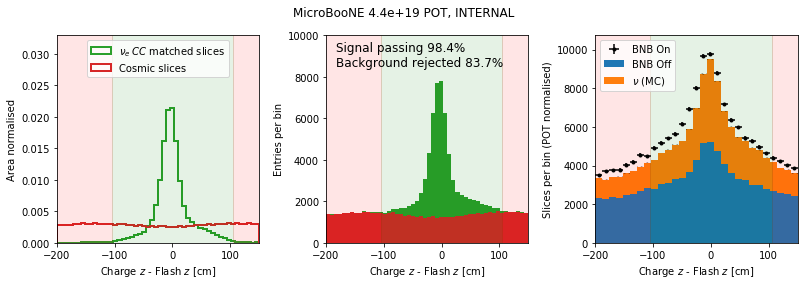

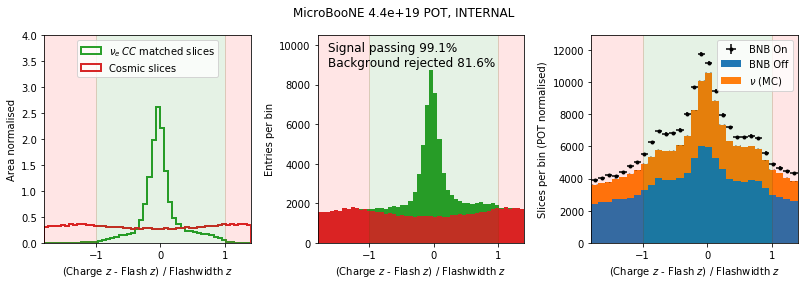

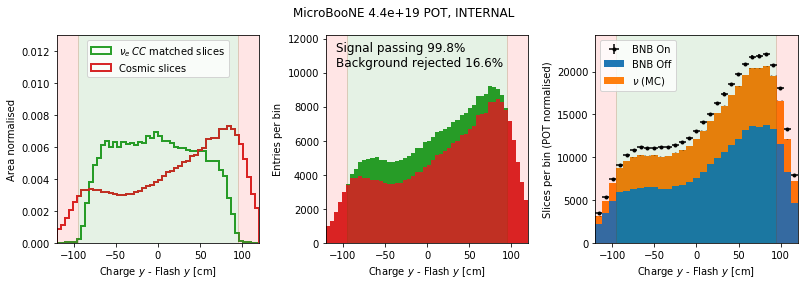

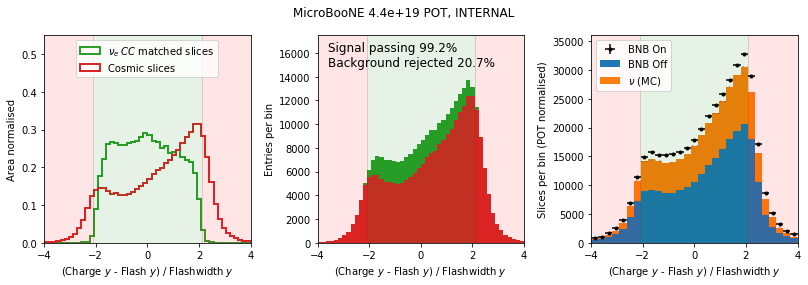

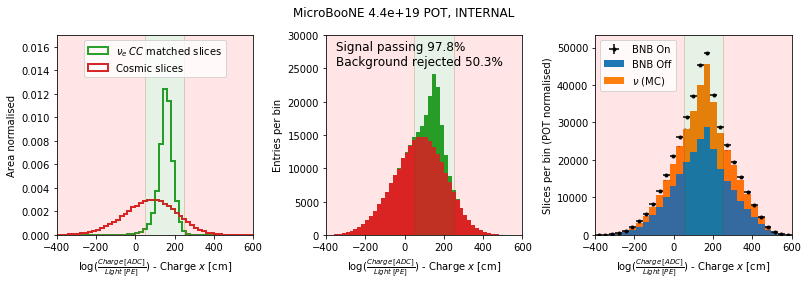

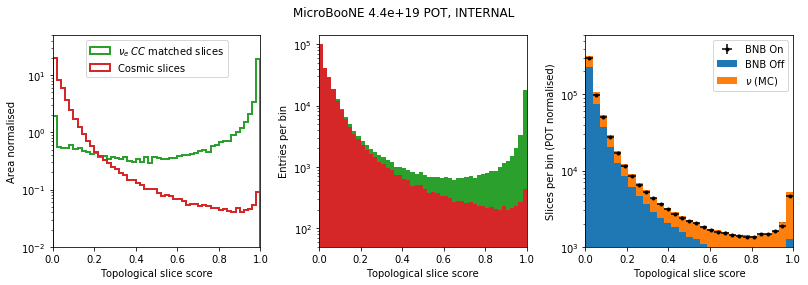

In [105]:
# Plotter
labels = ['Cosmic slices', r'$\nu_e \: CC$ matched slices']

for field_bin ,x_axis, x_min, x_max, bins, y_max, y_max2, cut in zip(plot_fields_bin, plot_x_axis, x_min_arr, x_max_arr, bins_arr, y_max_arr, y_max_2_arr ,cut_arr):
    
    fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharex=True)
    field = field_bin.decode('UTF-8')
    
    data_good = df_nue_slices_sig.query(query_perfect)[field]
    data_bad = df_nue_slices_sig.query(query_bad)[field]
    data = [data_bad,data_good]
    
    edges = np.linspace(x_min,x_max, bins+1)
    ax[0].hist(data, bins=edges, label=labels, histtype='step', lw=2, density=1, color=['C3','C2'])
    ax[1].hist(data, bins=edges, label=labels, histtype='barstacked', color=['C3','C2'])
    ax[0].set_xlabel(x_axis)
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('Entries per bin')
    ax[0].set_ylabel('Area normalised')
    ax[0].legend(loc='upper center')
    ax[0].set_ylim(0,y_max)
    ax[1].set_ylim(0,y_max2)
    ax[0].set_xlim(x_min,x_max)
    
    # Data/MC part of the plot
    ax[2].set_ylabel('Slices per bin (POT normalised)')
    data = [file_dict[s]['slices'][field_bin] for s in dict_names]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
    widths = (edges_mid - edges[:-1])

    ax[2].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[2].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[2].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
    y_err = np.sqrt(err[1]**2+err[3])
    val = bins[3]+bins[1]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[2].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[2].set_xlabel(x_axis)
    ax[2].set_ylim(0,1.1*max_val[2])
    ax[2].legend()
    
    print( sum(bins[2])/(sum(bins[1])+sum(bins[3])))

    # Precuts
    if isinstance(cut, list):
        #Ratio of good slices kept by this cut:
        mask_cut = (data_good>cut[0]) & (data_good<cut[1])
        ratio_kept = sum(mask_cut)/len(mask_cut) 
        print("Signal kept:\t",ratio_kept)
        mask_cut = (data_bad>cut[0]) & (data_bad<cut[1])
        ratio_bg = sum(mask_cut)/len(mask_cut) 
        print("BG rejected:\t",1-ratio_bg)
            
        text_x = x_min+(x_max-x_min)*0.05
        ax[1].text(text_x, y_max2*0.85, 'Signal passing {0:.1f}%\nBackground rejected {1:.1f}%'.format(ratio_kept*100,100-ratio_bg*100), fontsize=12)
        
        for ax_i in ax:
            ax_i.axvspan(x_min,cut[0], alpha=0.1, color="red")
            ax_i.axvspan(cut[0],cut[1], alpha=0.1, color="green")
            ax_i.axvspan(cut[1],x_max, alpha=0.1, color="red")
        
    elif cut!=0:
        #Ratio of good slices kept by this cut:
        mask_cut = (data_good>-cut) & (data_good<cut)
        ratio_kept = sum(mask_cut)/len(mask_cut) 
        print("Signal kept:\t",ratio_kept)
        mask_cut = (data_bad>-cut) & (data_bad<cut)
        ratio_bg = sum(mask_cut)/len(mask_cut) 
        print("BG rejected:\t",1-ratio_bg)

        text_x = x_min+(x_max-x_min)*0.05
        ax[1].text(text_x, y_max2*0.85, 'Signal passing {0:.1f}%\nBackground rejected {1:.1f}%'.format(ratio_kept*100,100-ratio_bg*100), fontsize=12)
        for ax_i in ax:
            ax_i.axvspan(x_min,-cut, alpha=0.1, color="red")
            ax_i.axvspan(-cut,cut, alpha=0.1, color="green")
            ax_i.axvspan(cut,x_max, alpha=0.1, color="red")
            
    # Topological score
    else:
        ax[0].set_ylim(0.01,y_max)
        ax[1].set_ylim(50,y_max2)
        ax[2].set_ylim(1000,2*max_val[2])
        for ax_i in ax:
            ax_i.set_yscale("log", nonposy='clip') 
    
    fig.suptitle(title_str)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    fig.savefig( outdir+field+".pdf")

Signal kept:	 0.9914508650910324
BG rejected:	 0.12304366693568991


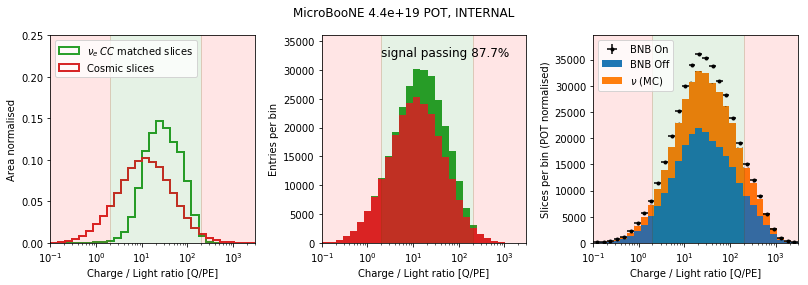

In [106]:
# make charge light ratio plot!
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharex=True)

x_min = 0.1
x_max = 3000
N=30
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
y_max = 0.25
y_max2= 36000

x_axis = r"Charge / Light ratio [Q/PE]"
field_bin = b'chargeToLightRatio'
field = field_bin.decode('UTF-8')

data_good = df_nue_slices_sig.query(query_perfect)[field]
data_bad = df_nue_slices_sig.query(query_bad)[field]
data = [data_bad,data_good]
#Ratio of good slices kept by this cut:
mask_cut = (data_good>2) & (data_good<200)
ratio_kept = sum(mask_cut)/len(mask_cut) 
print("Signal kept:\t",ratio_kept)
mask_cut = (data_bad>2) & (data_bad<200)
ratio_kept = sum(mask_cut)/len(mask_cut) 
print("BG rejected:\t",1-ratio_kept)
    

scale_log = [[1/len(d)]*len(d) for d in data]    
ax[0].hist(data, bins=edges, label=labels, histtype='step', lw=2, weights = scale_log, color=['C3','C2'])
ax[1].hist(data, bins=edges, label=labels, histtype='barstacked', color=['C3','C2'])

ax[1].set_ylabel('Entries per bin')
ax[0].set_ylabel('Area normalised')
ax[0].legend(loc='upper left')
ax[0].set_ylim(0,y_max)
ax[1].set_ylim(0,y_max2)
ax[0].set_xlim(x_min,x_max)

text_x = 2
ax[1].text(text_x, y_max2*0.9, 'signal passing {0:.1f}%'.format(ratio_kept*100), fontsize=12)

# Data/MC part of the plot
ax[2].set_ylabel('Slices per bin (POT normalised)')
data = [file_dict[s]['slices'][field_bin] for s in dict_names]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales, log=True)
widths = (edges_mid - edges[:-1])

ax[2].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
ax[2].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[2].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
y_err = np.sqrt(err[1]**2+err[3])
val = bins[3]+bins[1]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[2].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

ax[2].set_ylim(0,1.1*max_val[2])
ax[2].legend()


for ax_i in ax:
    ax_i.set_xlabel(x_axis)
    ax_i.set_xscale("log", nonposx='clip') 
    ax_i.axvspan(x_min,2, alpha=0.1, color="red")
    ax_i.axvspan(2,200, alpha=0.1, color="green")
    ax_i.axvspan(200,x_max, alpha=0.1, color="red")

fig.suptitle(title_str)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig( outdir+field+".pdf")

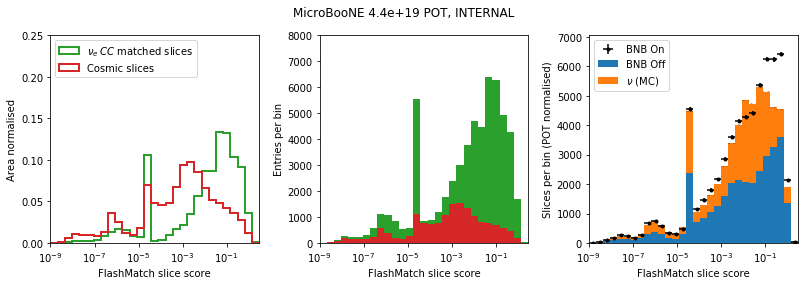

In [108]:
# make flashmatchscore plot!
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharex=True)

x_min = 1e-9
x_max = 3
N=30
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
y_max = 0.25
y_max2= 8000

x_axis = r"FlashMatch slice score"
field_bin = b'flashMatchScore'
field = field_bin.decode('UTF-8')

data_good = df_nue_slices_sig.query(query_perfect)[field]
data_bad = df_nue_slices_sig.query(query_bad)[field]
data = [data_bad,data_good]

scale_log = [[1/sum(d>1e-10)]*len(d) for d in data]     
ax[0].hist(data, bins=edges, label=labels, histtype='step', lw=2, weights = scale_log, color=['C3','C2'])
ax[1].hist(data, bins=edges, label=labels, histtype='barstacked', color=['C3','C2'])

ax[1].set_ylabel('Entries per bin')
ax[0].set_ylabel('Area normalised')
ax[0].legend(loc='upper left')
ax[0].set_ylim(0,y_max)
ax[1].set_ylim(0,y_max2)
ax[0].set_xlim(x_min,x_max)

# Data/MC part of the plot
ax[2].set_ylabel('Slices per bin (POT normalised)')
data = [file_dict[s]['slices'][field_bin] for s in dict_names]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales, log=True)
widths = (edges_mid - edges[:-1])

ax[2].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
ax[2].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[2].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
y_err = np.sqrt(err[1]**2+err[3])
val = bins[3]+bins[1]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[2].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

ax[2].set_ylim(0,1.1*max_val[2])
ax[2].legend()


for ax_i in ax:
    ax_i.set_xlabel(x_axis)
    ax_i.set_xscale("log", nonposx='clip') 

fig.suptitle(title_str)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig( outdir+field+".pdf")

In [109]:
# How much of the perfect slices is passing the precuts?
df_nue_perfect_slices = df_nue_slices_sig.query(query_perfect).copy()
df_nue_perfect_slices['passesPreCuts'].value_counts()/len(df_nue_perfect_slices)*100

True     95.329639
False     4.670361
Name: passesPreCuts, dtype: float64

In [110]:
# Percent of events in BNB off that passes the selection:
sum(file_dict['off']['events'][b'foundATargetSlice'])/len(file_dict['off']['events'][b'foundATargetSlice'])*100

21.424773248659243

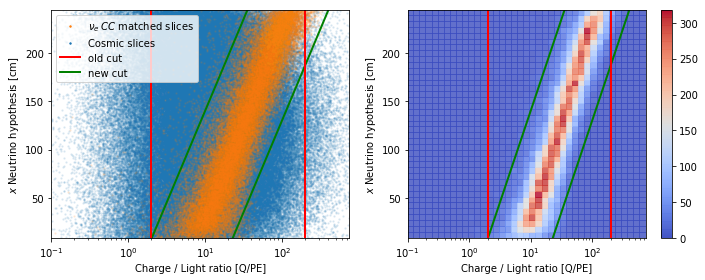

In [111]:
# Scatterplot to see xdependence on the charge light ratio!
N=1000000
m_xcl = 190

field = 'chargeToLightRatio'
x_good = df_nue_slices_sig.query(query_perfect)[field].head(N)
x_bad = df_nue_slices_sig.query(query_bad)[field].head(N)
x_data = [x_bad, x_good]
x_max = 750
x_min = 0.1
x_bins = 40
x_edges=np.logspace(np.log10(x_min),np.log10(x_max), x_bins)

field = 'centerX'
y_good = df_nue_slices_sig.query(query_perfect)[field].head(N)
y_bad = df_nue_slices_sig.query(query_bad)[field].head(N)
y_data = [y_bad, y_good]
y_max = upper[0]-fidvol_arr[0]
y_min = lower[0]+fidvol_arr[1]
y_bins = 40
y_edges=np.linspace(y_min,y_max, y_bins)

fig, ax = plt.subplots(ncols = 2, sharex=False, sharey = False, figsize=(10,4))
for x_arr, y_arr, lab in zip(x_data, y_data, labels):
    ax[0].scatter(x_arr, y_arr, s=2, alpha=0.1, label=lab)

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
ax[0].plot(mids_x, m_xcl*np.log10(mids_x)-50, color='g', lw=2, label='new cut')
ax[0].plot(mids_x, m_xcl*np.log10(mids_x)-250, color='g', lw=2)
ax[0].axvline(x=2, color='r', lw=2, label='old cut')
ax[0].axvline(x=200, color='r', lw=2)

handles, labels = ax[0].get_legend_handles_labels()
leg=ax[0].legend(handles[::-1], labels[::-1],loc="upper left")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax[0].set_xscale("log", nonposx='clip') 
ax[0].set_xlim(x_min,x_max)

ax[0].set_xlabel("Charge / Light ratio [Q/PE]")
ax[1].set_xlabel("Charge / Light ratio [Q/PE]")
ax[0].set_ylabel(r"$x$ Neutrino hypothesis [cm]")
ax[1].set_ylabel(r"$x$ Neutrino hypothesis [cm]")

h,_,_ = np.histogram2d(x_good,y_good, bins=(x_edges,y_edges))
X, Y = np.meshgrid(x_edges, y_edges)
im = ax[1].pcolormesh(X, Y, h.T, cmap='coolwarm', alpha=0.8)
clb = fig.colorbar(im, ax=ax[1])
ax[1].set_xscale('log')
ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

ax[1].plot(mids_x, m_xcl*np.log10(mids_x)-50, color='g', lw=2, label='new cut')
ax[1].plot(mids_x, m_xcl*np.log10(mids_x)-250, color='g', lw=2)
ax[1].axvline(x=2, color='r', lw=2, label='old cut')
ax[1].axvline(x=200, color='r', lw=2)

#y_mean = []
#y_err = []
#for n in h:
#    if sum(n)==0:
#        y_err.append(0)
#        y_mean.append(0)
#        continue
#    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
#    mean = np.average(mids_y, weights=n)
#    mean = mids_y[np.argmax(n)]
#    var = np.average((mids_y - mean)**2, weights=n)
#    y_err.append(np.sqrt(var))
#    y_mean.append(mean)
#print(y_mean)
#ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mpv+std per bin', alpha=0.7)
#ax[1].legend(loc='upper left')

fig.tight_layout()
fig.savefig(outdir+"scatter_x_charge_light.png", bbox_inches="tight", dpi=300)

## Make some slice level Data/MC plots

In [112]:
field_arr = [b'totalCharge', b'centerX', b'centerY', b'centerZ']
N_arr = [50,50,50,50]
x_min_arr = [0,*lower]
x_max_arr = [100000,*upper]
label_arr = ['Total charge per slice', 'Charge position of slice $x$ [cm]', 
             'Charge position of slice $y$ [cm]', 'Charge position of slice $z$ [cm]']
arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr]

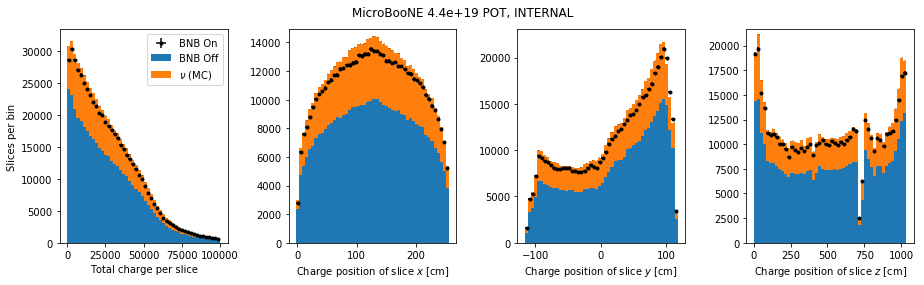

In [113]:
# hits and charge per slice
fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(8*gr,4))
fig.suptitle(title_str)

for i,(field, N, x_min, x_max, lab) in enumerate(zip(*arrays)):
    data = [file_dict[s]['slices'][field] for s in dict_names]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
    widths = (edges_mid - edges[:-1])

    # Data/MC
    ax[i].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[i].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[i].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
    y_err = np.sqrt(err[1]**2+err[3])
    val = bins[3]+bins[1]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[i].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[i].set_xlabel(lab)
    ax[i].set_ylim(0,1.1*max_val[2])

ax[0].legend()
ax[0].set_ylabel('Slices per bin')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig( outdir+"data_mc_slices_charge.pdf", bbox_inches="tight")